# CPU PERFORMANCE

This report will show the CPU performance data and it will predict the vendor that offers the best CPU in terms of performance.  
“Prediction” refers to the output of an algorithm after it has been trained on a historical dataset and applied to new data when forecasting the likelihood of a particular outcome (DataRobot Artificial Intelligence Wiki, n.d.).

The objective is to train the model to estimate the relative CPU performance using linear regression method. Create a Machine Learning application which can help in decision making based on the given data.

The dataset is based on 9 features and there are a total of 209 instances in it (Dua and Graff, 2019).

There are no empty fields so no additional formulas have to be apply here to fill in empty fields. 

This machine learning follows, mainly, the steps marked on https://www.cienciadedatos.net/ website (Amat Rodrigo, 2020)


# Libraries

In [132]:
# Data Processing
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Graphs
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Processin and Modeling
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

# Matplotlib configuration
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Data

In [133]:
# header: indicates if the dataset has an initial line with the name of each column
dataset = pd.read_csv('Computer-Hardware-Dataset-data-header.csv', sep = ',')

### Exploratory analysis

This section allows us to identify the data we are working with and any error in any of each column.

In [134]:
dataset.head(5)

,Vendor Name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,adviser,32/60,125,256,6000,256,16,128,198
1,amdahl,470v/7,29,8000,32000,32,8,32,269
2,amdahl,470v/7a,29,8000,32000,32,8,32,220
3,amdahl,470v/7b,29,8000,32000,32,8,32,172
4,amdahl,470v/7c,29,8000,16000,32,8,16,132


### Number of observations and missing values

It is important to know the number of data and if there is any missing value as it will affect the rest of machine learning. If this is the case, additional formulas will be used to amend those variables.

In [135]:
# Dataset dimensions
# ==============================================================================
dataset.shape

(209, 9)

In [136]:
# Number of NULL per variable
# ==============================================================================
dataset.isna().sum().sort_values()

Vendor Name    0
Model Name     0
MYCT           0
MMIN           0
MMAX           0
CACH           0
CHMIN          0
CHMAX          0
PRP            0
dtype: int64

** No variable contains missing values **

In [137]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Vendor Name  209 non-null    object
 1   Model Name   209 non-null    object
 2   MYCT         209 non-null    int64 
 3   MMIN         209 non-null    int64 
 4   MMAX         209 non-null    int64 
 5   CACH         209 non-null    int64 
 6   CHMIN        209 non-null    int64 
 7   CHMAX        209 non-null    int64 
 8   PRP          209 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 13.1+ KB


### PRP variable

When creating a model, it is very important to study the distribution of the response variable, since, in the end, it is what we want to predict

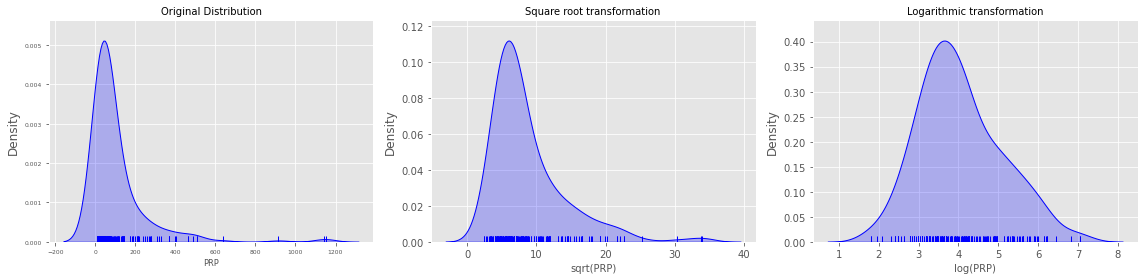

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
sns.distplot(
    dataset.PRP,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Original Distribution", fontsize = 'medium')
axes[0].set_xlabel('PRP', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(dataset.PRP),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Square root transformation", fontsize = 'medium')
axes[1].set_xlabel('sqrt(PRP)', fontsize='medium') 
axes[1].tick_params(labelsize = 10)

sns.distplot(
    np.log(dataset.PRP),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Logarithmic transformation", fontsize = 'medium')
axes[2].set_xlabel('log(PRP)', fontsize='medium') 
axes[2].tick_params(labelsize = 10)

fig.tight_layout()

### Numeric Variables

In [139]:
# Num Variables
# ==============================================================================
dataset.select_dtypes(include=['int64', 'object']).describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000


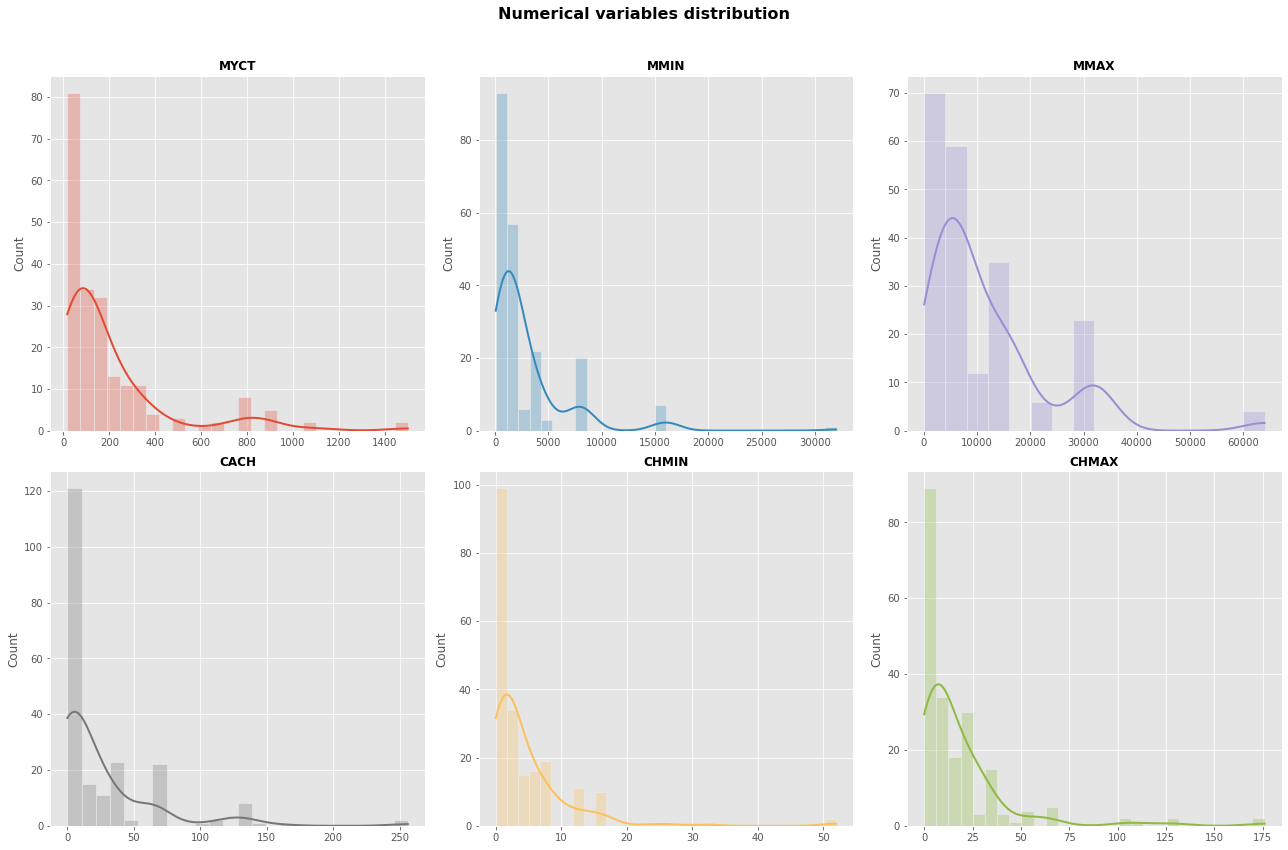

In [140]:
# Distribution graph for each numerical variable
# ==============================================================================
# Adjust number of subplots based on the number of columns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flat
num_columns = dataset.select_dtypes(include=['int64']).columns
num_columns = num_columns.drop('PRP')

for i, colum in enumerate(num_columns):
    sns.histplot(
        data    = dataset,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Numerical variables distribution', fontsize = 16, fontweight = "bold");

The CACH variable, although of type numeric, takes a few values. In cases like this, it is often convenient to treat the variable as qualitative.

In [141]:
# Observed CACH values
# ==============================================================================
dataset.CACH.value_counts()

0      69
8      31
32     23
64     20
16     14
4       8
24      7
128     6
6       5
2       4
30      4
1       2
9       2
256     2
48      2
65      2
112     2
131     2
12      1
142     1
96      1
160     1
Name: CACH, dtype: int64

In [142]:
# The string type CACH variable is converted
# ==============================================================================
dataset.CACH = dataset.CACH.astype("str")

As the objective of the study is to predict the cpu relative performance, the analysis of each variable is also done in relation to the PRP response variable. By analyzing the data in this way, you can begin to get ideas about which variables are most related to PRP and in what way.

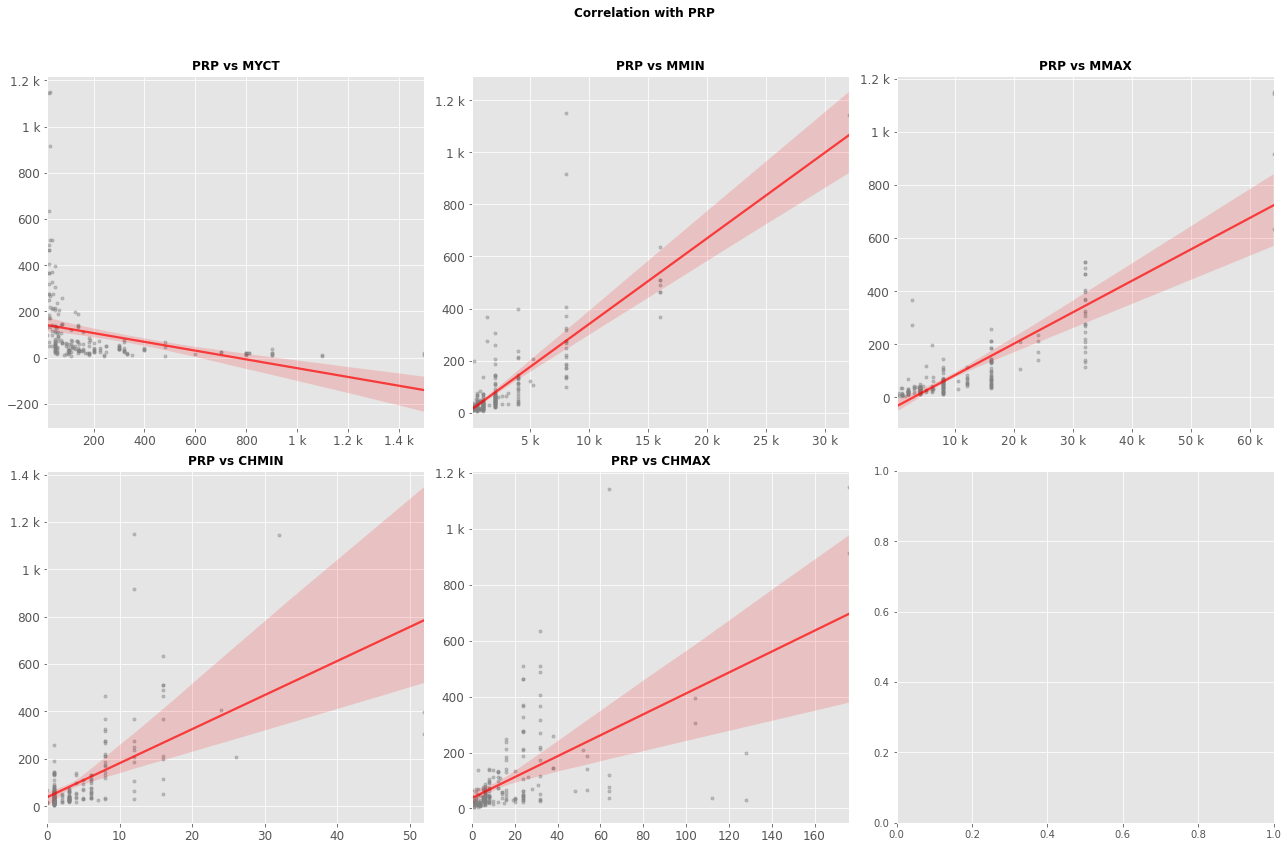

In [143]:
# Distribution graph for each numerical variable
# ==============================================================================
# Adjust number of subplots based on the number of columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flat
num_columns = dataset.select_dtypes(include=['int64']).columns
num_columns = num_columns.drop('PRP')

for i, colum in enumerate(num_columns):
    sns.regplot(
        x           = dataset[colum],
        y           = dataset['PRP'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"PRP vs {colum}", fontsize = 12, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Empty axes are removed
#for i in [7,8]:
#    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlation with PRP', fontsize = 12, fontweight = "bold");

### Numerical variables correlation

Some models suffer if they incorporate highly correlated predictors. For this reason, it is convenient to study the degree of correlation between the available variables.

In [144]:
# Correlation between numeric columns
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Function to convert a pandas correlation matrix to tidy format
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = dataset.select_dtypes(include=['int64']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
32,PRP,MMAX,0.863004,0.863004
17,MMAX,PRP,0.863004,0.863004
11,MMIN,PRP,0.794931,0.794931
31,PRP,MMIN,0.794931,0.794931
8,MMIN,MMAX,0.758157,0.758157
13,MMAX,MMIN,0.758157,0.758157
23,CHMIN,PRP,0.608903,0.608903
33,PRP,CHMIN,0.608903,0.608903
34,PRP,CHMAX,0.605209,0.605209
29,CHMAX,PRP,0.605209,0.605209


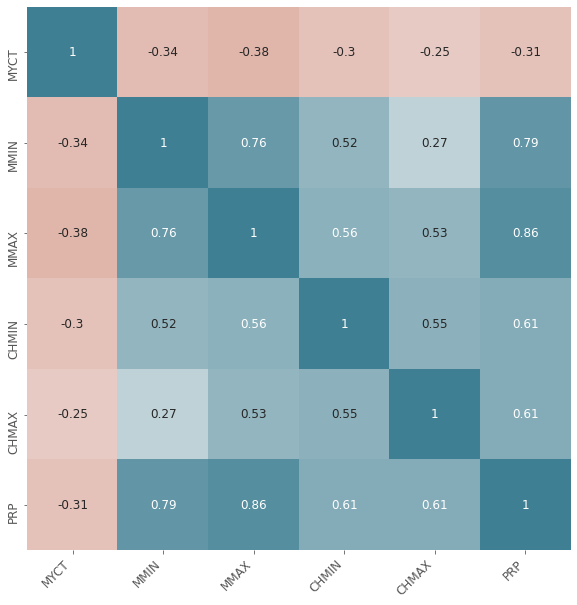

In [145]:
# Heatmap matrix of correlations
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 12},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 12)

### Qualitative variables

In [146]:
# Qualitative variables (object type)
# ==============================================================================
dataset.select_dtypes(include=['object']).describe()

,Vendor Name,Model Name,CACH
count,209,209,209
unique,30,209,22
top,ibm,universe:2203t,0
freq,32,1,69


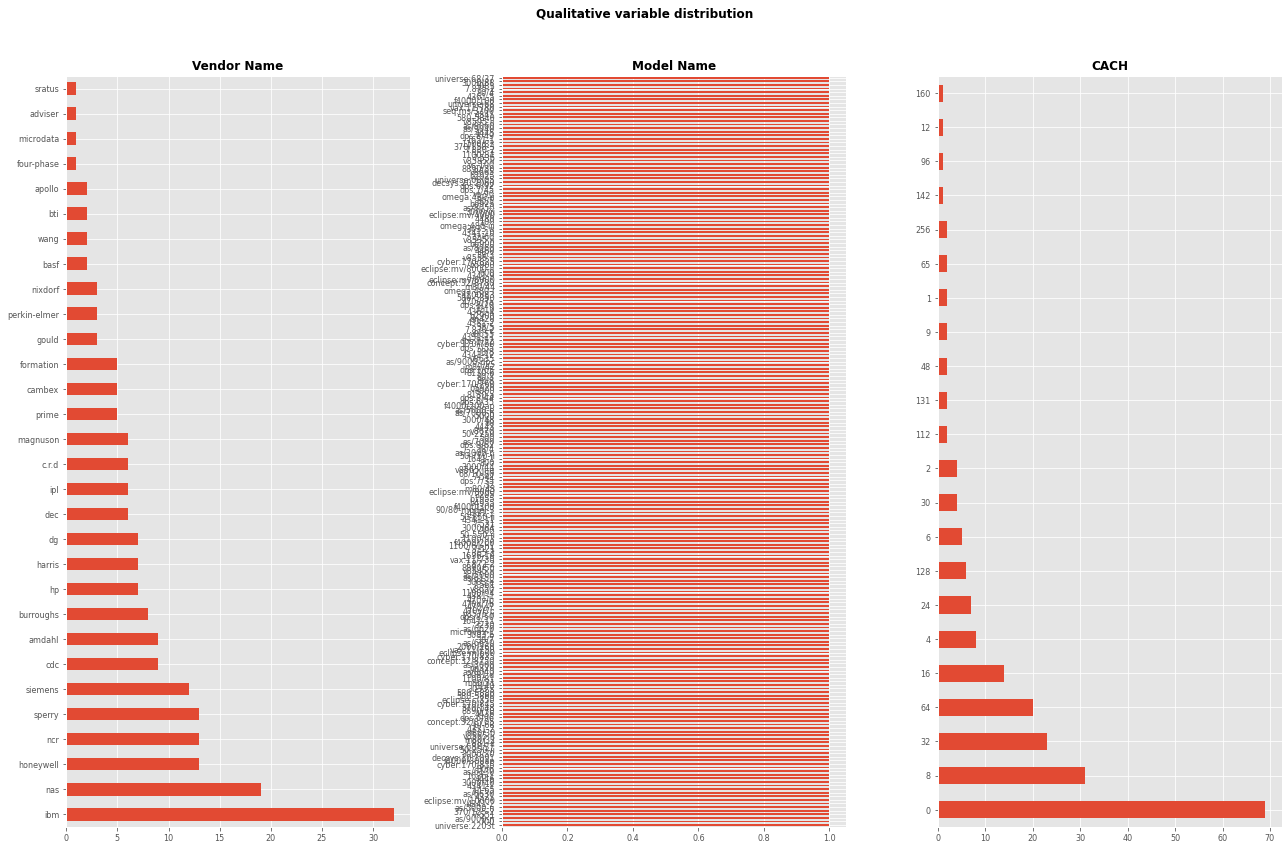

In [147]:
# Graph for each qualitative variable
# ==============================================================================
# Adjust number of subplots based on the number of columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 12))
axes = axes.flat
object_columns = dataset.select_dtypes(include=['object']).columns

for i, colum in enumerate(object_columns):
    dataset[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")

# Empty axes are removed
#for i in [4,5]:
#    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Qualitative variable distribution',
             fontsize = 12, fontweight = "bold");

If any of the levels of a qualitative variable have very few observations compared to the other levels, it may happen that, during cross-validation, some partitions do not contain any observations of that class (zero variance), which can lead to errors . In these cases, it is usually convenient:

- Eliminate the minority group observations if it is a multiclass variable.

- Delete the variable if it only has two levels.

- Group minority levels into a single group.

- Ensure that, when creating partitions, all groups are represented in each one of them.

In this case, we have to be careful with the CACH variable. Levels 4 upwards are unified into a new level called "4_plus".

In [148]:
dataset.CACH.value_counts(sort=True)

0      69
8      31
32     23
64     20
16     14
4       8
24      7
128     6
6       5
30      4
2       4
112     2
131     2
48      2
9       2
1       2
65      2
256     2
142     1
96      1
12      1
160     1
Name: CACH, dtype: int64

In [149]:
dic_replace = {'4': "4_plus",
               '24': "4_plus",
               '128': "4_plus",
               '6' : "4_plus",
               '2' : "4_plus",
               '30' : "4_plus",
               '131' : "4_plus",
               '1' : "4_plus",
               '48' : "4_plus",
               '112' : "4_plus",
               '9' : "4_plus",
               '256' : "4_plus",
               '65' : "4_plus",
               '160' : "4_plus",
               '12' : "4_plus",
               '96' : "4_plus",
               '142' : "4_plus"}

dataset['CACH'] = dataset['CACH'] \
                     .map(dic_replace) \
                     .fillna(dataset['CACH'])

In [150]:
dataset.CACH.value_counts(sort=True).sort_index()

0         69
16        14
32        23
4_plus    52
64        20
8         31
Name: CACH, dtype: int64

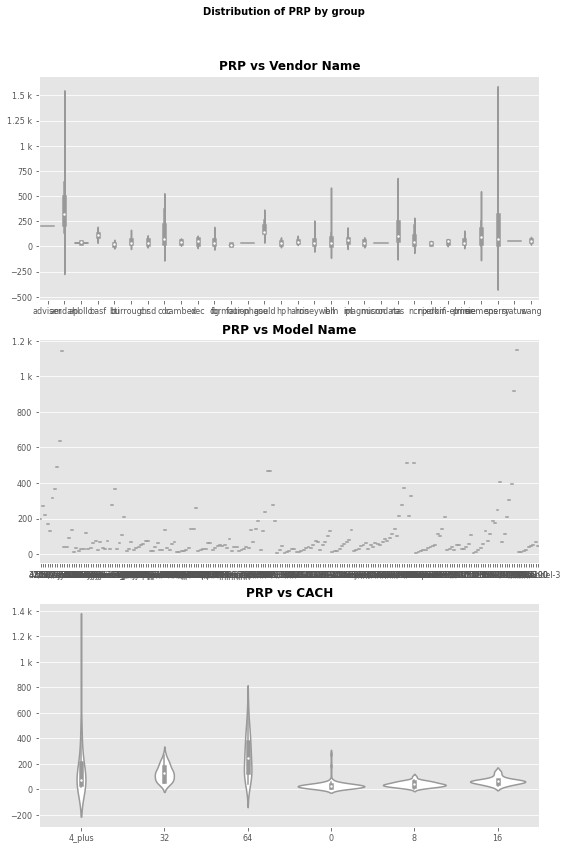

In [151]:
# Graph of the relationship between the PRP and each qualitative variable
# ==============================================================================
# Adjust number of subplots based on the number of columns
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))
axes = axes.flat
object_columns = dataset.select_dtypes(include=['object']).columns

for i, colum in enumerate(object_columns):
    sns.violinplot(
        x     = colum,
        y     = 'PRP',
        data  = dataset,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"PRP vs {colum}", fontsize = 12, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
#for i in [7, 8]:
#    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribution of PRP by group', fontsize = 10, fontweight = "bold");

# Train and Test division

As a supervised learning model, the linear division of the data set is made into, at least, two parts, train and test. The proper size of the partitions depends largely on the amount of data available and the security that is needed in estimating the error, 80% -20% usually gives good results.

In [152]:
# Distribution of data in train and test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        dataset.drop('PRP', axis = 'columns'),
                                        dataset['PRP'],
                                        train_size   = 0.8,
                                        random_state = 21,
                                        shuffle      = True
                                    )

In [153]:
print("Training partition")
print("-----------------------")
print(y_train.describe())

Training partition
-----------------------
count     167.000000
mean       92.982036
std       135.511413
min         6.000000
25%        25.000000
50%        44.000000
75%        92.500000
max      1150.000000
Name: PRP, dtype: float64


In [154]:
print("Test partition")
print("-----------------------")
print(y_test.describe())

Test partition
-----------------------
count      42.000000
mean      155.880952
std       231.598391
min        12.000000
25%        36.250000
50%        62.000000
75%       138.000000
max      1144.000000
Name: PRP, dtype: float64


# Preprocessing

Data preprocessing in Machine Learning is a crucial step that helps enhance the quality of data to promote the extraction of meaningful insights from the data. Data preprocessing in Machine Learning refers to the technique of preparing (cleaning and organizing) the raw data to make it suitable for a building and training Machine Learning models (Goyal, 2020).

### Pipeline and Column Transformer

This allows transformation learning to be done with training observations only, and can then be applied to any data set.

In [158]:
# Selection of variables by type
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )


Once the ColumnTransformer object has been defined, the fit () method learns the transformations with the training data and applies them to the two sets with transform ()

In [159]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

The result returned by ColumnTransformer is a numpy array, so the columns names are lost. It is usually interesting to be able to inspect how the dataset looks after preprocessing in dataframe format. By default, OneHotEncoder sorts new columns alphabetically from left to right.

In [164]:
from sklearn import set_config
set_config(display='diagram')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 []),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Vendor Name', 'Model Name', 'CACH'])])

In [165]:
set_config(display='text')

# Creating Model

The next step after defining the training data is to select the algorithm to be used.

### Training

In [166]:
from sklearn.linear_model import Ridge

# Preprocessing
# ==============================================================================

# Identification of numerical and categorical columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Pipeline
# ==============================================================================

# The preprocessing steps and the model are combined in the same pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Train
# ==============================================================================
# The result is assigned to _ so that it is not printed on the screen
_ = pipe.fit(X=X_train, y=y_train)

### Validation

In [167]:
# Cross-Validation
# ==============================================================================
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )

print(f"Cross validation metrics: {cv_scores}")
print(f"Average cross-validation metrics: {cv_scores.mean()}")

Cross validation metrics: [-135.14100652  -54.7584836   -68.2291514   -96.39371947  -35.19977582]
Average cross-validation metrics: -77.94442736314126


In [169]:
# Repeated cross validation with multiple metrics
# ==============================================================================
from sklearn.model_selection import cross_validate

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

# Converts to dataframe for easy viewing
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.048007,0.191974,0.741798,0.963241,-53.267337,-28.298196
1,0.028426,0.015998,0.608318,0.960877,-113.337530,-20.498964
2,0.024017,0.008002,0.559069,0.969085,-67.794951,-26.135588
3,0.031996,0.007999,0.673675,0.959636,-100.289474,-21.924272
4,0.023978,0.008001,0.671426,0.970317,-68.742252,-24.386724
5,0.023996,0.008001,0.730034,0.962505,-49.282081,-29.159699
6,0.023998,0.007999,0.593114,0.985533,-111.898184,-13.072795
7,0.024039,0.008003,0.799169,0.959877,-57.216021,-27.735666
8,0.016027,0.008058,0.619946,0.961535,-50.579079,-30.091116
9,0.015999,0.007998,0.696592,0.966172,-68.052947,-25.849814


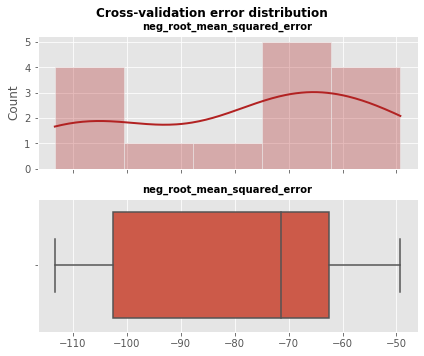

In [170]:
# Cross-validation error distribution
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)

sns.histplot(
    data    = cv_scores['test_neg_root_mean_squared_error'],
    stat    = "count",
    kde     = True,
    line_kws= {'linewidth': 2},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
)

axes[0].set_title('neg_root_mean_squared_error', fontsize = 10, fontweight = "bold")
axes[0].tick_params(labelsize = 10)
axes[0].set_xlabel("")
    
sns.boxplot(
    cv_scores['test_neg_root_mean_squared_error'],
    ax      = axes[1]
)
axes[1].set_title('neg_root_mean_squared_error', fontsize = 10, fontweight = "bold")
axes[1].tick_params(labelsize = 10)
axes[1].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Cross-validation error distribution', fontsize = 12,
             fontweight = "bold");

In [171]:
# Parallelized repeated cross validation (multicore)
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv,
                n_jobs    = -1 
             )

print(f"Cross-validation metrics: {cv_scores.mean()}")

Cross-validation metrics: -70.72234477440612


The average 'root_mean_squared_error' estimated by cross-validation for this model is 70. This value will be checked later when the error of the model is calculated with the test set.

# Prediction

Once the model has been trained, new observations can be predicted with the .predict () method.

In [172]:
predictions = pipe.predict(X_test)

In [173]:
# A dataframe is created with the predictions and the actual value
df_predictions = pd.DataFrame({'PRP' : y_test, 'prediction' : predictions})
df_predictions.head()

,PRP,prediction
156,510,486.403910
17,28,41.608395
54,26,14.565859
6,367,451.421728
9,1144,991.206341


# Test error

Although the validation methods provide good estimates of the error that a model has when predicting new observations, the best way to evaluate a final model is by predicting a test set.

In [174]:
# neg_root_mean_squared_error de test
# ==============================================================================
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predictions,
        squared = False
       )
rmse

54.74629400301501

**In the validation section, it was estimated, by repeated cross-validation, that the rmse of the model was 70, a value close to that obtained with the test set 54**

# Hyperparameters (tuning)

The most common way to find optimal values is by trying different possibilities.

1. Choose a set of values for the hyperparameters.

    - grid search: an exhaustive search is made on a set of values previously defined by the user.

    - random search: random values are evaluated within user-defined limits.

2. For each value (combination of values if there is more than one hyperparameter), train the model and estimate its error using a validation method.

3. Finally, fit the model again, this time with all the training data and the best hyperparameters found.

### Grid search

In [175]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge
import multiprocessing

# Pipe: preprocessed + model
# ==============================================================================
# Identification of numerical and category columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# The preprocessing steps and the model are combined in the same pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('model', Ridge())])

# Grid of hyperparameters
# ==============================================================================
param_grid = {'model__alpha': np.logspace(-5, 3, 10)}

# Cross-validation search
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        return_train_score = True
       )

# The result is assigned to _ so that it is not printed on the screen
_ = grid.fit(X = X_train, y = y_train)

In [176]:
# Grid results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_model__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
9,1000,-69.799450,33.243521,-60.193062,8.707701
8,129.155,-70.157932,34.141134,-58.748316,8.576308
7,16.681,-70.169578,34.163101,-52.629328,7.746231
6,2.15443,-72.738663,33.918674,-35.416716,5.328842
5,0.278256,-75.151293,33.718290,-10.923655,1.651326
4,0.0359381,-75.770966,33.651194,-1.731038,0.261184
3,0.00464159,-75.867262,33.643839,-0.247216,0.037521
2,0.000599484,-75.878458,33.643841,-0.090676,0.027152
1,7.74264e-05,-75.882074,33.640948,-0.081043,0.027694
0,1e-05,-75.883257,33.642204,-0.089268,0.028168


In [177]:
# Better hyperparameters
# ==============================================================================
print("-----------------------------------")
print("Best hyperparameters found")
print("-----------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

-----------------------------------
Best hyperparameters found
-----------------------------------
{'model__alpha': 1000.0} : -69.79945016319596 neg_root_mean_squared_error


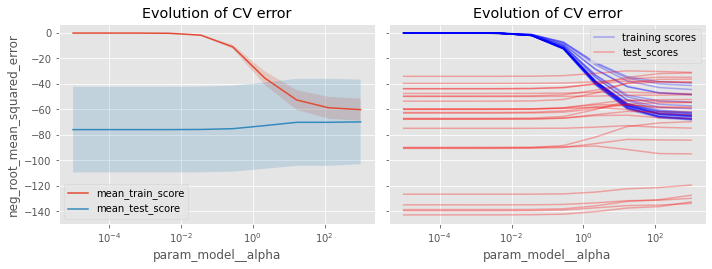

In [178]:
# Cross-validation results graph for each hyperparameter
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.84), sharey=True)

# Graph 1
# ------------------------------------------------------------------------------
results.plot('param_model__alpha', 'mean_train_score', ax=axes[0])
results.plot('param_model__alpha', 'mean_test_score', ax=axes[0])
axes[0].fill_between(results.param_model__alpha.astype(np.float),
                results['mean_train_score'] + results['std_train_score'],
                results['mean_train_score'] - results['std_train_score'],
                alpha=0.2)
axes[0].fill_between(results.param_model__alpha.astype(np.float),
                results['mean_test_score'] + results['std_test_score'],
                results['mean_test_score'] - results['std_test_score'],
                alpha=0.2)
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('Evolution of CV error')
axes[0].set_ylabel('neg_root_mean_squared_error');

# Graph 2
# ------------------------------------------------------------------------------
numero_splits = grid.n_splits_

results.plot(
    x     = 'param_model__alpha',
    y     = [f'split{i}_train_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'blue', 
    ax    = axes[1]
)

results.plot(
    x     = 'param_model__alpha',
    y     = [f'split{i}_test_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'red', 
    ax    = axes[1]
)

axes[1].legend(
    (axes[1].get_children()[0], axes[1].get_children()[numero_splits]),
    ('training scores', 'test_scores')
)
axes[1].set_xscale('log')
axes[1].set_title('Evolution of CV error')
axes[1].set_ylabel('neg_root_mean_squared_error');

fig.tight_layout()


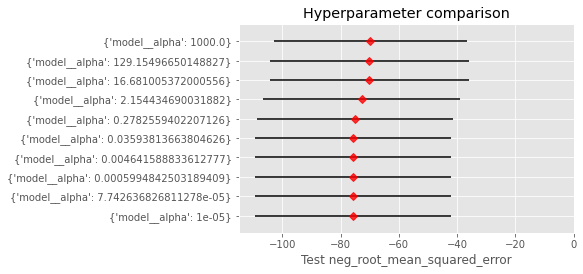

In [179]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.barh(
    [str(d) for d in results['params']],
    results['mean_test_score'],
    xerr=results['std_test_score'],
    align='center',
    alpha=0
)
ax.plot(
    results['mean_test_score'],
    [str(d) for d in results['params']],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Hyperparameter comparison')
ax.set_xlabel('Test neg_root_mean_squared_error');

# Algorithms

In the following sections, different machine learning models are trained in order to compare them and identify the one that obtains the best result by predicting the PRP. For this purpose, we are using RMSE (Root mean square error)

### Linear Regression - Ridge model

In [180]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge


# Pipeline: preprocessed + model
# ==============================================================================
# Identification of numerical and category columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# The preprocessing steps and the model are combined in the same pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('model', Ridge())])

# Hyperparameter optimization
# ==============================================================================
# Search space for each hyperparameter
param_distributions = {'model__alpha': np.logspace(-5, 5, 500)}

# Random grid search

grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Grid results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_model__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
17,22841.1,-68.510278,30.443158,-61.776204,7.025406


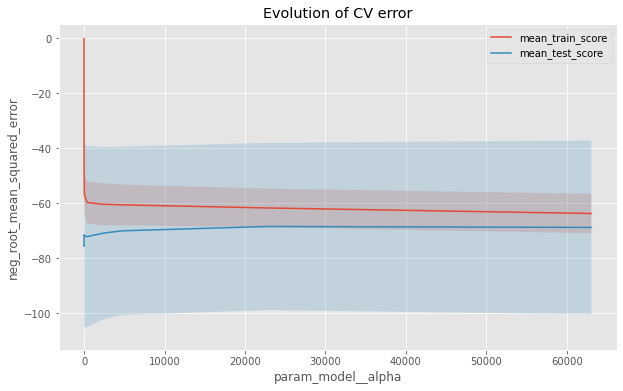

In [181]:
# Cross-validation results graph for each hyperparameter
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
hyperparameter = 'param_model__alpha'
results = results.sort_values(hyperparameter, ascending = False)
metric  = grid.scoring

results.plot(hyperparameter, 'mean_train_score', ax=ax)
results.plot(hyperparameter, 'mean_test_score', ax=ax)
ax.fill_between(results[hyperparameter].astype(np.int),
                results['mean_train_score'] + results['std_train_score'],
                results['mean_train_score'] - results['std_train_score'],
                alpha=0.2)
ax.fill_between(results[hyperparameter].astype(np.int),
                results['mean_test_score'] + results['std_test_score'],
                results['mean_test_score'] - results['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolution of CV error')
ax.set_ylabel(metric);

In [183]:
# Final model test error
# ==============================================================================
final_model = grid.best_estimator_
predictions = final_model.predict(X = X_test)
rmse_Ridge = mean_squared_error(
            y_true  = y_test,
            y_pred  = predictions,
            squared = False
          )
print(f"The test error (rmse) is: {rmse_Ridge}")

The test error (rmse) is: 64.37911558813138


### Random Forest

In [184]:
from sklearn.ensemble import RandomForestRegressor

# Pipeline: preprocessed + model
# ==============================================================================
# Identification of numerical and category columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# The preprocessing steps and the model are combined in the same pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('model', RandomForestRegressor())])

# Hyperparameter optimization
# ==============================================================================
# Search space for each hyperparameter

param_distributions = {
    'model__n_estimators': [100, 120, 300, 500, 800, 1200],
    'model__max_features': ["auto", 3, 5, 7],
    'model__max_depth'   : [None, 3, 5, 10, 20]
}

# Random grid search

grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Grid results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_model__n_estimators,param_model__max_features,param_model__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
15,1200,auto,10,-65.382046,43.960529,-29.999456,5.907923


In [185]:
# Final model test error
# ==============================================================================
final_model = grid.best_estimator_
predictions = final_model.predict(X = X_test)
rmse_rf = mean_squared_error(
            y_true  = y_test,
            y_pred  = predictions,
            squared = False
          )
print(f"The test error (rmse) is: {rmse_rf}")

The test error (rmse) is: 90.05493757640951


### Linear Regression - Lasso model

In [186]:
from sklearn.linear_model import Lasso


# Pipeline: preprocessed + model
# ==============================================================================
# Identification of numerical and category columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# The preprocessing steps and the model are combined in the same pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('model', Lasso())])

# Hyperparameter optimization
# ==============================================================================
# Search space for each hyperparameter
param_distributions = {'model__alpha': np.logspace(-5, 5, 500)}

# Random grid search

grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Grid results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_model__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.38831,-64.723837,35.005198,-25.194818,0.823163


In [187]:
# Final model test error
# ==============================================================================
final_model = grid.best_estimator_
predictions = final_model.predict(X = X_test)
rmse_Lasso = mean_squared_error(
            y_true  = y_test,
            y_pred  = predictions,
            squared = False
          )
print(f"The test error (rmse) is: {rmse_Lasso}")

The test error (rmse) is: 81.02031400848261


### Gradient Boosting Trees

In [190]:
from sklearn.ensemble import GradientBoostingRegressor

# Pipeline: preprocessed + model
# ============================================================================
# Identification of numerical and category columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# The preprocessing steps and the model are combined in the same pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('model', GradientBoostingRegressor())])

# Hyperparameter optimization
# =============================================== =============================
# Search space for each hyperparameter

param_distributions = {
    'model__n_estimators': [50, 100, 1000, 2000],
    'model__max_features': ["auto", 3, 5, 7],
    'model__max_depth'   : [None, 3, 5, 10, 20],
    'model__subsample'   : [0.5,0.7, 1]
}

# Random grid search
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Grid results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_model__subsample,param_model__n_estimators,param_model__max_features,param_model__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
6,0.5,2000,7,5,-66.249609,42.430968,-0.000302,0.000053


In [191]:
# Final model test error
# ==============================================================================
final_model = grid.best_estimator_
predictions = final_model.predict(X = X_test)
rmse_gbm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predictions,
            squared = False
          )
print(f"The test error (rmse) is: {rmse_gbm}")

The test error (rmse) is: 93.21710036910925


### Stacking

Each model is capable of approaching the correct value but it will not give us the solution to the problem. To do this, combining those models with more different results, we can compensate the results. For this, we will use the Ridge models, with the lowest error, and the Gradient Boosting Tree, with the highest value.

We proceed to create a stacking with the Ridge and GradrientBoostingTree models, using in each case the best hyperparameters found in the previous sections.

In [215]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

# Pipeline: preprocessed + model
# ============================================================================
# Identification of numerical and category columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Preprocessing steps and models are combined by creating multiple pipelines.
pipe_ridge = Pipeline([('preprocessing', preprocessor),
                     ('ridge', Ridge(alpha=22841))])

#pipe_rf = Pipeline([('preprocessing', preprocessor),
#                     ('random_forest', RandomForestRegressor(
#                                         n_estimators = 1200,
#                                         max_features = "auto",
#                                         max_depth    = 10
#                                        )
#                     )])

#pipe_lasso = Pipeline([('preprocessing', preprocessor),
#                      ('lasso', Lasso(alpha=0.4))])

pipe_gbt = Pipeline ([('preprocessing', preprocessor),
                                       ('gradient_boosting_tree', GradientBoostingRegressor(
                                                                  n_estimators = 2000,
                                                                  max_features = 7,
                                                                  max_depth    = 5,
                                                                  subsample    = 0.5
                                                                  )
                                       )])

In [216]:
# Definition and training of the StackingRegressor
# ==============================================================================
estimators = [('ridge', pipe_ridge),
#              ('random_forest', pipe_rf),
#              ('lasso', pipe_lasso),
              ('gradient_boosting_tree', pipe_gbt)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())
# The result is assigned to _ so that it is not printed on the screen
_ = stacking_regressor.fit(X = X_train, y = y_train)


In [217]:
# Stacking test error
# ==============================================================================
final_model = stacking_regressor
predictions = final_model.predict(X = X_test)
rmse_stacking = mean_squared_error(
                    y_true  = y_test,
                    y_pred  = predictions,
                    squared = False
                  )
print(f"The test error (rmse) is: {rmse_stacking}")


The test error (rmse) is: 61.69128246355352


# Comparison

The test error of all the trained models is compared.

The test error using Linear Regression - Lasso model is:  81.02031400848261
The test error using Linear Regression - Ridge model is:  64.37911558813138
The test error using Random Forest model is:  90.05493757640951
The test error using Gradient Boosting Trees is:  93.21710036910925
The test error using Stackings is:  61.69128246355352


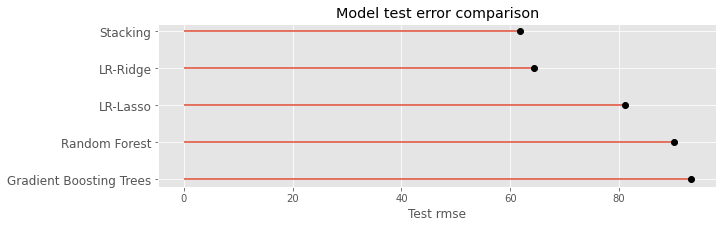

In [218]:
error_models = pd.DataFrame({
                        'model': ['LR-Ridge', 'Random Forest', 'LR-Lasso', 'Gradient Boosting Trees', 'Stacking'],
                        'rmse': [rmse_Ridge, rmse_rf, rmse_Lasso, rmse_gbm, rmse_stacking]
                     })
error_models = error_models.sort_values('rmse', ascending=False)

fig, ax = plt.subplots(figsize=(10, 3))
ax.hlines(error_models.model, xmin=0, xmax=error_models.rmse)
ax.plot(error_models.rmse, error_models.model, "o", color='black')
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_title('Model test error comparison'),
ax.set_xlabel('Test rmse');
print ('===========================================================================')
print ('The test error using Linear Regression - Lasso model is: ', rmse_Lasso)
print ('The test error using Linear Regression - Ridge model is: ', rmse_Ridge)
print ('The test error using Random Forest model is: ', rmse_rf)
print ('The test error using Gradient Boosting Trees is: ', rmse_gbm)
print ('The test error using Stackings is: ', rmse_stacking)
print ('===========================================================================')

**********************************************************************************************
**********************************************************************************************

According to the previous result, we can see that the linear regression model is the one that gives the best result when predicting the best result for the model studied.

## References

Amat Rodrigo, J. (2020). Machine Learning Con Python Y Scikitlearn. [online] www.cienciadedatos.net. Available at: https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html.

DataRobot Artificial Intelligence Wiki (n.d.). Prediction | DataRobot Artificial Intelligence Wiki. [online] DataRobot. Available at: https://www.datarobot.com/wiki/prediction/#:~:text=What%20does%20Prediction%20mean%20in

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository: Computer Hardware Data Set. [online] Uci.edu. Available at: https://archive.ics.uci.edu/ml/datasets/Computer+Hardware

Goyal, K. (2020). Data Preprocessing in Machine Learning: 7 Easy Steps to Follow. [online] upGrad blog. Available at: https://www.upgrad.com/blog/data-preprocessing-in-machine-learning/.